##Anomaly Detection with an Autoencoder
An autoencoder is a type of neural network that can learn a compressed representation of the input data by encoding it into a lower-dimensional space and then decoding it back to its original dimensionality. See: https://arxiv.org/pdf/2201.03898.pdf

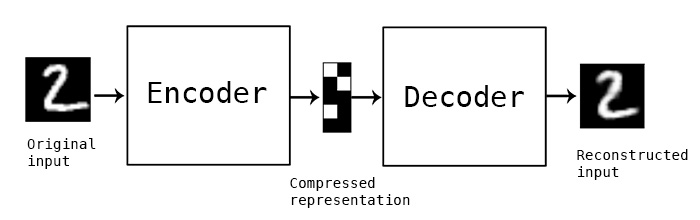


Basically, hidden layers are small, allowing for a compact representation of information (embedding). 

In the context of anomaly detection the idea is:
* During training, the autoencoder is trained to minimize the difference between the input and output data, i.e., the reconstruction error;
* So the model learns to reconstruct the output with low reconstruction error, using a compressed representation of the input data that captures the salient features of the inlier samples; 
* However, when presented with outlier samples, the decoder that attempts to reconstruct the input data from this compressed representation will have high reconstruction error;
* Therefore, we can use the reconstruction error as a measure of how anomalous a sample is: samples with high reconstruction error are more likely to be outliers than samples with low reconstruction error.

# Simulating some data and train/test the model
We simulate some date, set-up the encoder and then train/test it.
Here we use a **Supervised approach**: we (assume) we have labels.

The architecture of the autoencoder used in this example consists of:
* Input layer - this layer takes the input data, which in this case is a two-dimensional vector representing the coordinates of the data points;
* Hidden layer 1 - this layer is a fully connected layer with four neurons and uses ReLU activation function;
* Encoding layer - his layer is also a fully connected layer, but with only two neurons, which forces the autoencoder to learn a compressed representation of the input data; the activation function used is ReLU;
* Hidden layer 2 - this layer is another fully connected layer with four neurons and ReLU activation function;
* Output layer - this layer produces the reconstructed output, which is the same shape as the input data, and it is also a fully connected layer with linear activation function (the linear activation function is used in the output layer of the autoencoder because the goal of the autoencoder is to reconstruct the input data as accurately as possible, and the linear activation function allows the output to take on any real value).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Generate data with inliers and outliers
np.random.seed(42)

inliers_mean = [0, 0]
inliers_cov = [[1, 0], [0, 1]]
inliers = np.random.multivariate_normal(inliers_mean, inliers_cov, size=3000)

outliers_mean = [6, 6]
outliers_cov = [[1, 0], [0, 1]]
outliers = np.random.multivariate_normal(outliers_mean, outliers_cov, size=60)

X = np.concatenate([inliers, outliers])
y = np.concatenate([np.zeros(len(inliers)), np.ones(len(outliers))])

# Split data into train and test sets
train_ratio = 0.8
train_size = int(len(X)*train_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 2
hidden_dim = 4

input_layer = Input(shape=(input_dim,))
hidden_layer_1 = Dense(hidden_dim, activation='relu')(input_layer)
encoded_layer = Dense(encoding_dim, activation='relu')(hidden_layer_1)
hidden_layer_2 = Dense(hidden_dim, activation='relu')(encoded_layer)
output_layer = Dense(input_dim)(hidden_layer_2)

model = Model(input_layer, output_layer)

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on test set
reconstruction_errors = np.mean(np.power(X_test - model.predict(X_test), 2), axis=1)
reconstruction_errors_train = np.mean(np.power(X_train - model.predict(X_train), 2), axis=1)

# Set threshold based on reconstruction error distribution of inlier samples
threshold = np.percentile(reconstruction_errors_train, 97.5)
anomalies = np.where(reconstruction_errors > threshold)[0]
normal = np.where(reconstruction_errors <= threshold)[0]
print(f"{len(anomalies)} anomalies and {len(normal)} normal samples detected.")

Epoch 1/100
123/123 [==============================] - 1s 5ms/step - loss: 0.7118 - val_loss: 0.5566
Epoch 2/100
123/123 [==============================] - 0s 3ms/step - loss: 0.4948 - val_loss: 0.3946
Epoch 3/100
123/123 [==============================] - 0s 3ms/step - loss: 0.3582 - val_loss: 0.2871
Epoch 4/100
123/123 [==============================] - 0s 3ms/step - loss: 0.2636 - val_loss: 0.2129
Epoch 5/100
123/123 [==============================] - 0s 3ms/step - loss: 0.1941 - val_loss: 0.1496
Epoch 6/100
123/123 [==============================] - 0s 2ms/step - loss: 0.1371 - val_loss: 0.1042
Epoch 7/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0972 - val_loss: 0.0712
Epoch 8/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0692 - val_loss: 0.0486
Epoch 9/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0336
Epoch 10/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0353 - val_lo

# Predictions
Let's use the estimated model to do a prediction on freshly simulated data...

In [8]:
# Create new simulated data and make prediction
inliers_new = np.random.multivariate_normal(inliers_mean, inliers_cov, size=100)
outliers_new = np.random.multivariate_normal(outliers_mean, outliers_cov, size=50)
X_new = np.concatenate([inliers_new, outliers_new])
y_new = np.concatenate([np.zeros(len(inliers_new)), np.ones(len(outliers_new))])

reconstruction_errors_new = np.mean(np.power(X_new - model.predict(X_new), 2), axis=1)
anomalies_new = np.where(reconstruction_errors_new > threshold)[0]
normal_new = np.where(reconstruction_errors_new <= threshold)[0]
print(f"{len(anomalies_new)} anomalies and {len(normal_new)} normal samples detected.")

5/5 [==============================] - 0s 2ms/step
53 anomalies and 97 normal samples detected.


#Unsupervised approach
Alternatively, one could also use an **unsupervised approach** where the autoencoder is trained only on inlier samples and the threshold is set based on the reconstruction error distribution of the inlier samples. This approach does not require any labeled outlier samples for training and can work well when the distribution of outliers is significantly different from that of inliers.

Try.